In [2]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

from Tarjet import *
from Phisicsparams import *
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase


In [3]:
from typing import TypeVarTuple


params = Params()
params.thickness_sup = 0.2
params.N_layers = 25

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.09
  params.n_max = 2.6
  params.M_discretion_n = 200
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en otro lado
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup =  15
params.numIter = 300
params.sigma = 0.035
params.batch_size = 100
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 16                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 256                                                                               # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 26                                                                              # Dimension de la Capa de entrada
params.lr = 0.05                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [5]:
params.condiciones = 2
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.2

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 45
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.generate_physics_params()
# physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()



In [6]:
if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)

In [7]:

tarjet.tarjets["tarjet_1"].view(-1)[190:] = 1

tarjet.tarjets["tarjet_2"].view(-1)[115:] = 1



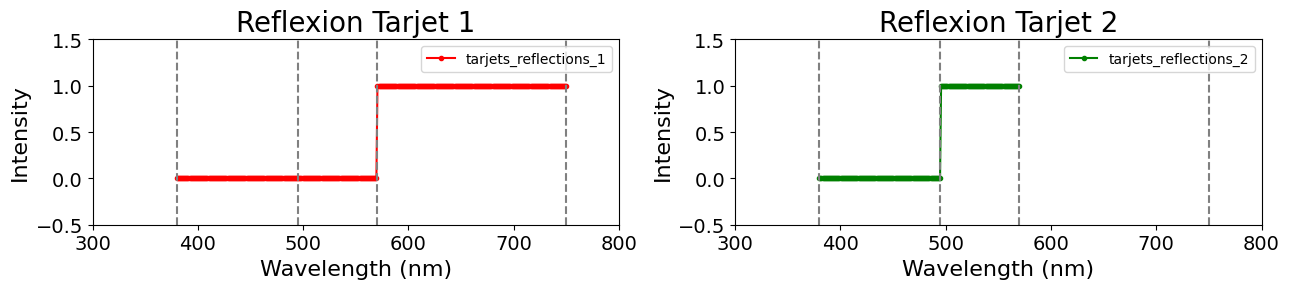

In [8]:
# Subplots para Reflexiones
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet.tarjets["tarjet_1"].view(-1), ".-", color="red", label="tarjets_reflections_1")
        ax.set_title("Reflexion Tarjet 1", fontsize=20)
    elif i == 1:
        ax.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet.tarjets["tarjet_2"].view(-1), ".-", color="green", label="tarjets_reflections_2")
        ax.set_title("Reflexion Tarjet 2", fontsize=20)

    ax.set_xlabel("Wavelength (nm)", fontsize=16)
    ax.set_ylabel("Intensity", fontsize=16)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Agregar líneas verticales punteadas
    for line_pos in vertical_lines:
        ax.axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()


100%|██████████| 200/200 [04:00<00:00,  1.20s/it]


iteration1


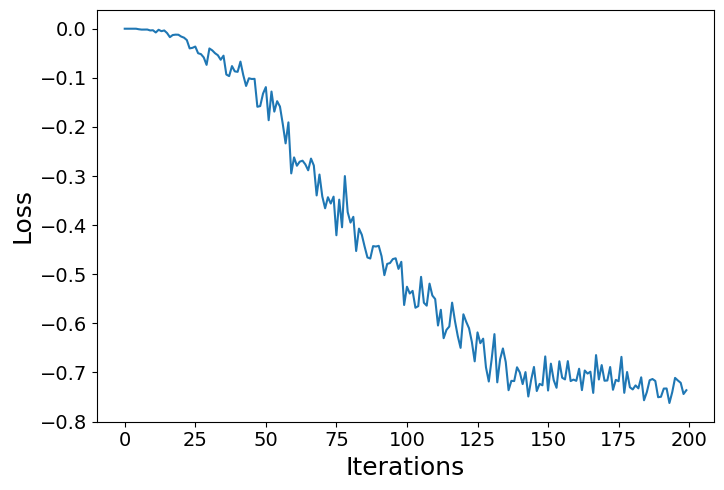

In [32]:
for seed in range(1):                                                # Generacion del comando for para las semillas (0, ->(cantidad de semillas aleatorias), 1)
  params.seed = seed

  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  glonet.viz_training()
  print(f"iteration{seed + 1 }")


Espesores: tensor([0.0913, 0.1411, 0.0692, 0.0494, 0.1663, 0.1600, 0.1558, 0.0575, 0.0034,
        0.0024, 0.0036, 0.0143, 0.1314, 0.0021, 0.0072, 0.0023, 0.0567, 0.1987,
        0.1678, 0.0786])
Indices de refracción: tensor([[1.6136],
        [1.3632],
        [2.2510],
        [2.1751],
        [2.4179],
        [1.4770],
        [1.4163],
        [2.4558],
        [1.1507],
        [1.1052],
        [1.2418],
        [1.2418],
        [1.2721],
        [1.3328],
        [1.4997],
        [2.3420],
        [2.5848],
        [2.4328],
        [1.1583],
        [2.3931]], dtype=torch.float64)


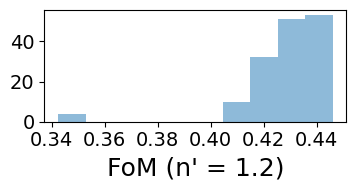

In [22]:
with torch.no_grad():
    params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
    params.theta_test = torch.linspace(0, math.pi/2.25, 50)
    (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
    reflex = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)  # Solo reflex, ignora transmix
    
    # Calcular FoM solo para reflexiones de tarjet_1 y tarjet_2
    FoM_reflex_total = 0
    for i in range(1, 3):  # Solo consideramos tarjet_1 y tarjet_2
        reflex_key = f'reflexion_{i}'
        tarjet_key = f'tarjet_{i}'
        r = reflex[reflex_key]
        FoM_reflex = torch.pow(r - tarjet.tarjets[tarjet_key], 2).mean(dim=[1, 2, 3])  
        FoM_reflex_total += FoM_reflex

    # Visualización del FoM total
    plt.figure(figsize=(10, 2))
    plt.subplot(131)
    plt.hist(FoM_reflex_total.cpu().detach().numpy(), alpha=0.5)
    plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Encontrar el índice óptimo
    _, indices = torch.sort(FoM_reflex_total)
    opt_idx = indices[0]

    optimal_thicknesses = thicknesses[opt_idx]
    optimal_ref_idx = ref_index[opt_idx]

    print("Espesores:", optimal_thicknesses)
    print("Indices de refracción:", optimal_ref_idx)

    # Guardar reflexiones óptimas para tarjet_1 y tarjet_2
    optimal_reflections = {}

    for i in range(1, 3):  # Solo consideramos tarjet_1 y tarjet_2
        reflex_key = f'reflexion_{i}'
        optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]


In [9]:

thicknesses_list = []
ref_idx_list = []

figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

histogram_dir = "Histogramas"
os.makedirs(histogram_dir, exist_ok=True)
    
Loss_dir =  "Losses"
if not os.path.exists(Loss_dir):
    os.makedirs(Loss_dir)


xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]



for seed in range(50):                                                
  params.seed = seed
  params.sigma = np.random.uniform(0.025, 0.05)

  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  
  plt.figure(figsize = (20, 5))
  plt.subplot(131)
  plt.plot(glonet.loss_training)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Iterations', fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  
  plt.savefig(f"{Loss_dir}/Loss_seed_{seed}.png", bbox_inches='tight')
  plt.close()
  
  print(f"iteration{seed + 1 }")

  with torch.no_grad():
      params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
      params.theta_test = torch.linspace(0, math.pi/2.25, 50)
      (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
      # Optimizacion
      
      reflex = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
      FoM_reflex_total = sum(torch.pow(reflex[f'reflexion_{i}'] - tarjet.tarjets[f'tarjet_{i}'], 2).mean(dim=[1, 2, 3]) for i in range(1, 3))
      _, indices = torch.sort(FoM_reflex_total)
      opt_idx = indices[0]

      # Visualización del FoM total
      
      plt.figure(figsize=(10, 2))
      plt.subplot(131)
      plt.hist(FoM_reflex_total.cpu().detach().numpy(), alpha=0.5)
      plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.savefig(f"{histogram_dir}/histograma_seed_{seed}.png", bbox_inches='tight')
      plt.close()
      
      # Encontrar el índice óptimo
      _, indices = torch.sort(FoM_reflex_total)
      opt_idx = indices[0]

      optimal_thicknesses = thicknesses[opt_idx]
      optimal_ref_idx = ref_index[opt_idx]
      
      thicknesses_list.append(optimal_thicknesses.view(-1).cpu().numpy().tolist())
      ref_idx_list.append(optimal_ref_idx.view(-1).cpu().numpy().tolist())

          
 
  fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
  fig.subplots_adjust(wspace=0.4)
  
  # Definir optimal_reflections
  optimal_reflections = {}
  
  for i in range(1, 3):  # Solo 1 y 2
      reflex_key = f'reflexion_{i}'
      optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
      
      # Gráfico de reflexión óptima
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                    "-", color="violet", label="Optimal Reflexion")
  
      # Gráfico de reflexión de tarjeta
      tarjet_color = "red" if i == 1 else "green"
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    tarjet.tarjets[f"tarjet_{i}"].view(-1),
                    ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)
  
      axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
      axs[i-1].set_ylabel("Reflection", fontsize=16)
      axs[i-1].legend(fontsize=10)
      axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
      axs[i-1].tick_params(axis='both', which='major', labelsize=14)
      axs[i-1].set_xlim(xlim)
      axs[i-1].set_ylim(ylim)
  
      # Agregar líneas verticales punteadas para reflexiones
      for line_pos in vertical_lines:
          axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')
          
  fig.savefig(os.path.join(figures_dir, f"reflexion_seed_{seed}.png"))
  plt.close(fig)

with open('optimal_thicknesses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(thicknesses_list)

# Archivo CSV para los índices de refracción
with open('optimal_ref_idx.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ref_idx_list)
    

    


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


iteration1


100%|██████████| 300/300 [06:40<00:00,  1.34s/it]


iteration2


100%|██████████| 300/300 [06:43<00:00,  1.35s/it]


iteration3


100%|██████████| 300/300 [06:41<00:00,  1.34s/it]


iteration4


100%|██████████| 300/300 [06:40<00:00,  1.33s/it]


iteration5


100%|██████████| 300/300 [06:42<00:00,  1.34s/it]


iteration6


100%|██████████| 300/300 [06:41<00:00,  1.34s/it]


iteration7


100%|██████████| 300/300 [06:41<00:00,  1.34s/it]


iteration8


100%|██████████| 300/300 [06:38<00:00,  1.33s/it]


iteration9


100%|██████████| 300/300 [06:43<00:00,  1.35s/it]


iteration10


100%|██████████| 300/300 [06:40<00:00,  1.34s/it]


iteration11


100%|██████████| 300/300 [06:44<00:00,  1.35s/it]


iteration12


100%|██████████| 300/300 [07:00<00:00,  1.40s/it]


iteration13


100%|██████████| 300/300 [06:40<00:00,  1.34s/it]


iteration14


100%|██████████| 300/300 [06:44<00:00,  1.35s/it]


iteration15


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


iteration16


100%|██████████| 300/300 [06:42<00:00,  1.34s/it]


iteration17


100%|██████████| 300/300 [06:42<00:00,  1.34s/it]


iteration18


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


iteration19


100%|██████████| 300/300 [06:40<00:00,  1.33s/it]


iteration20


100%|██████████| 300/300 [06:44<00:00,  1.35s/it]


iteration21


100%|██████████| 300/300 [06:50<00:00,  1.37s/it]


iteration22


100%|██████████| 300/300 [06:46<00:00,  1.36s/it]


iteration23


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


iteration24


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


iteration25


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


iteration26


100%|██████████| 300/300 [06:46<00:00,  1.36s/it]


iteration27


100%|██████████| 300/300 [06:49<00:00,  1.37s/it]


iteration28


100%|██████████| 300/300 [06:48<00:00,  1.36s/it]


iteration29


100%|██████████| 300/300 [06:48<00:00,  1.36s/it]


iteration30


100%|██████████| 300/300 [06:51<00:00,  1.37s/it]


iteration31


100%|██████████| 300/300 [06:41<00:00,  1.34s/it]


iteration32


100%|██████████| 300/300 [06:43<00:00,  1.35s/it]


iteration33


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


iteration34


100%|██████████| 300/300 [06:46<00:00,  1.35s/it]


iteration35


100%|██████████| 300/300 [06:54<00:00,  1.38s/it]


iteration36


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


iteration37


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


iteration38


100%|██████████| 300/300 [06:48<00:00,  1.36s/it]


iteration39


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


iteration40


100%|██████████| 300/300 [06:46<00:00,  1.36s/it]


iteration41


100%|██████████| 300/300 [06:42<00:00,  1.34s/it]


iteration42


100%|██████████| 300/300 [06:48<00:00,  1.36s/it]


iteration43


100%|██████████| 300/300 [06:49<00:00,  1.36s/it]


iteration44


100%|██████████| 300/300 [1:11:30<00:00, 14.30s/it]    


iteration45


100%|██████████| 300/300 [06:01<00:00,  1.21s/it]


iteration46


100%|██████████| 300/300 [06:51<00:00,  1.37s/it]


iteration47


100%|██████████| 300/300 [06:46<00:00,  1.36s/it]


iteration48


100%|██████████| 300/300 [06:49<00:00,  1.37s/it]


iteration49


100%|██████████| 300/300 [06:57<00:00,  1.39s/it]


iteration50


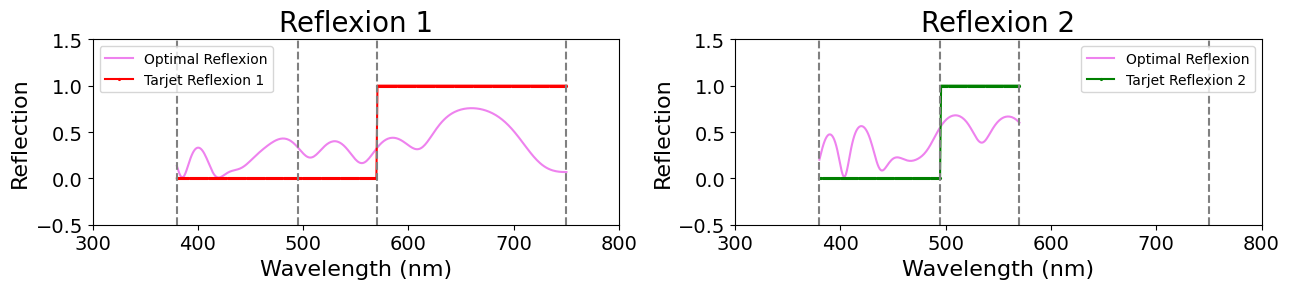

Espesores: tensor([0.0992, 0.1104, 0.1289, 0.1207, 0.0979, 0.0833, 0.0679, 0.1032, 0.0754,
        0.0453, 0.0440, 0.0413, 0.0835, 0.0592, 0.0855, 0.0350, 0.0551, 0.0564,
        0.0649, 0.1078, 0.1238, 0.0888, 0.0673, 0.0722, 0.0759])
Índices de refracción: tensor([2.2943, 2.3951, 1.4694, 1.7354, 1.9702, 1.7653, 1.2873, 1.6529, 2.5393,
        1.9702, 1.6287, 1.2645, 2.2054, 1.2418, 1.1128, 1.5714, 2.2358, 1.0900,
        2.0349, 2.4710, 1.5908, 1.4522, 1.1811, 1.4315, 2.2359],
       dtype=torch.float64)


In [51]:
# Definir xlim, ylim y vertical_lines
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

# Subplots para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)

# Definir optimal_reflections
optimal_reflections = {}

for i in range(1, 3):  # Solo 1 y 2
    reflex_key = f'reflexion_{i}'
    optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
    
    # Gráfico de reflexión óptima
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                  "-", color="violet", label="Optimal Reflexion")

    # Gráfico de reflexión de tarjeta
    tarjet_color = "red" if i == 1 else "green"
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  tarjet.tarjets[f"tarjet_{i}"].view(-1),
                  ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)

    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
    axs[i-1].set_ylabel("Reflection", fontsize=16)
    axs[i-1].legend(fontsize=10)
    axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
    axs[i-1].tick_params(axis='both', which='major', labelsize=14)
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)

    # Agregar líneas verticales punteadas para reflexiones
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()

print("Espesores:", optimal_thicknesses.view(-1))
print("Índices de refracción:", optimal_ref_idx.view(-1))


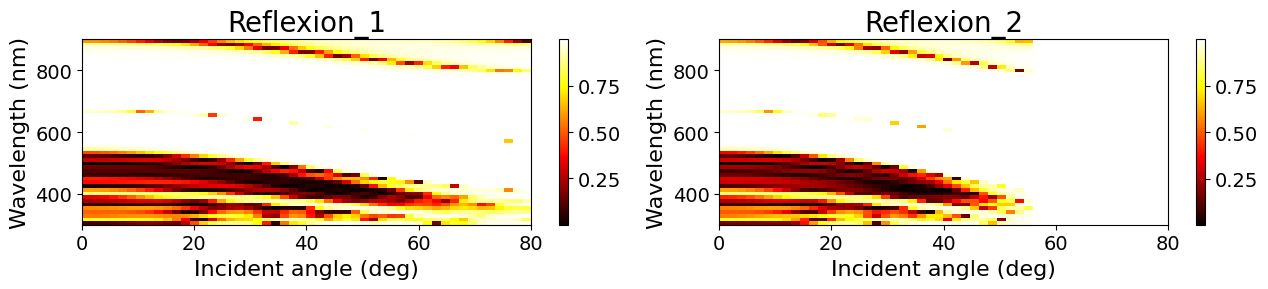

In [37]:
(thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
r = []
params.k_test = 2 * math.pi / torch.linspace(0.3, 0.9, 50)
params.theta_test = torch.linspace(0, math.pi/2.25, 50)

for i in range(2):  # Solo 2 iteraciones para reflexion_1 y reflexion_2
    r_  = TMM_solver(thicknesses, 
                        ref_index, 
                        getattr(physicsparams, f'n_top_{i + 1}'), 
                        getattr(physicsparams, f'n_bot_{i + 1}'),
                        params.k_test,
                        params.theta_test)
    r.append(r_)

_ ,  index = torch.sort(FoM_reflex_total)
opt_inx =  index[0]

# Gráficos para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)
for i in range(2):  # Solo 2 gráficos para reflexion_1 y reflexion_2
    im1 = axs[i].imshow(r[i][opt_inx, : , 0, :].detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 900])
    cbar1 = fig.colorbar(im1, ax=axs[i])
    cbar1.ax.tick_params(labelsize=14)
    axs[i].set_title(f'Reflexion_{i + 1}', fontsize=20)  # Reflexion_{1} y Reflexion_{2}
    axs[i].set_xlabel('Incident angle (deg)', fontsize=16)
    axs[i].set_ylabel('Wavelength (nm)', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

plt.show()
